# k arm bandit 

this notebook is an attmpt to create a k armed bandit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
#set variables
k = 10
reward_range_min = 1
reward_range_max = 10
std_min = 1
std_max = 1
samples_per_distrib = 1000



In [3]:
#create arms and rewards
reward_stack = []
max_mean = 0
best_arm = 0

for i in range(0,k):
    #select mean for this arm
    current_mean = np.random.choice(a = list(range(reward_range_min,reward_range_max+1)), size = 1)
    
    if max_mean == current_mean:
        current_mean += 1 
    
    if max_mean < current_mean:
        max_mean = current_mean
        best_arm = i
        
    #to debug
    print(i , current_mean)
    
    #select std for this arm
    current_std = np.random.choice(a = list(range(std_min,std_max+1)), size = 1)
    #to debug
    #print(current_std)
    
    #draw samples for this arm
    current_arm = np.random.normal(loc = current_mean, scale = current_std, size = samples_per_distrib)
    #to debug
    #print(current_arm)
    
    #append to reward stack list 
    reward_stack.append(current_arm)
    #to debug
    #print(reward_stack)
    
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  


0 [5]
1 [4]
2 [2]
3 [9]
4 [7]
5 [5]
6 [10]
7 [6]
8 [9]
9 [9]
the maximum mean is : [10]
the best arm is : 6


{'bodies': [<matplotlib.collections.PolyCollection at 0x22e5ac52af0>,
 'cmeans': <matplotlib.collections.LineCollection at 0x22e5ac528e0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x22e5ac7b4f0>,
 'cmins': <matplotlib.collections.LineCollection at 0x22e5ac7b970>,
 'cbars': <matplotlib.collections.LineCollection at 0x22e5ac7bdf0>,
 'cmedians': <matplotlib.collections.LineCollection at 0x22e5ac882b0>}

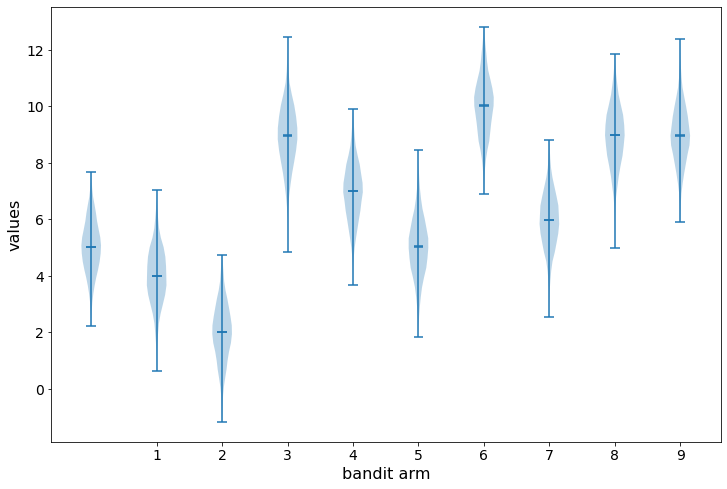

In [4]:
#alter plot size so it looks decent
#makes viz bigger
import matplotlib.pyplot as plt
BIG = 16
MED = 14
SMALL = 10
plt.rcParams.update({'font.size': BIG})
plt.rcParams.update({'axes.labelsize': BIG})
plt.rcParams.update({'xtick.labelsize': MED})
plt.rcParams.update({'ytick.labelsize': MED})
plt.rcParams.update({'figure.figsize':[12, 8]}) #this is important as it makes the visualizations much easier to read and clip/export!(w,h)

#plot reward stack and arms
plt.xticks(ticks=list(range(1,k+1)), labels=list(range(1,k+1)))

plt.xlabel("bandit arm")

plt.ylabel("values")

plt.violinplot(reward_stack, list(range(0,k)), points=20, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=True)



In [5]:
#random selection without any value assesments

#set base vars
n = 1000

#set objects needed
arms_selected = []
total_reward = 0

for i in range(0,n):
    
    #randomly pick an arm
    current_arm = np.random.choice(range(0,k))
    
    #append choice to list tracking what was done
    arms_selected.append(current_arm)
    
    #randomly pick a reward from the distrib
    current_reward = np.random.choice(reward_stack[current_arm])
    
    #add current reward to total rewards
    total_reward = total_reward + current_reward
    

print("total reward from random selection:",total_reward)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print(pd.Series(arms_selected).value_counts(normalize = True).sort_index())

total reward from random selection: 6670.930758002051
the maximum mean is : [10]
the best arm is : 6
0    0.110
1    0.104
2    0.087
3    0.109
4    0.101
5    0.074
6    0.104
7    0.108
8    0.109
9    0.094
dtype: float64


In [6]:
#epsilon greedy solution

#example for setting base vars
n = 1000
reward_step = .9 #used with nonstationary tracking, set to one for stationary problems
epsilon = 0.1

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

##############################################################################################
#some basic helper functions
##############################################################################################

#use epsilon to make explouit or explore decision:
def exploit_or_explore(epsilon):
    
    exp = np.random.binomial(1, epsilon, 1)
    
    return exp

#value assesment
def arm_max(expected_rewards):
    
    maxx = np.argsort(expected_rewards)[-1]
    
    #debug
    #print(expected_rewards)
    #print(maxx)
    
    return maxx
    
#pull the arm selected
def pull_arm(current_arm):
    
    current_reward = np.random.choice(reward_stack[current_arm])
    
    return current_reward   

##############################################################################################
#some not so basic helper functions
##############################################################################################

#update reward expectations
def update_reward_expectation(expected_rewards, last_reward_list, reward_step, current_arm):
    
    prior_tweaked = (reward_step * (last_reward_list[current_arm] - expected_rewards[current_arm]))
    
    #debug
    #print(prior_tweaked)
    
    expected_rewards[current_arm] = expected_rewards[current_arm] + prior_tweaked
    
    #print(expected_rewards)
    
    return expected_rewards

#when epsilon is used for exploration
#select arm that has been selected the least number of times or random arm (not selecting the max arm)
def arm_explore(expected_rewards, count_arms_selected):
         
    #get the number of times each arm has been selected
    arm_breakdown = np.array(count_arms_selected)
    
    #check if first two are equal
    sorted_arm_indices = arm_breakdown.argsort()
    
    #debug
    #print(arm_breakdown)
    #print(sorted_arm_indices)
    #print("0:",arm_breakdown[sorted_arm_indices[0]])
    #print("1:",arm_breakdown[sorted_arm_indices[1]])
    
    #if first do not have equal counts then return lowest count
    if arm_breakdown[sorted_arm_indices[0]] != arm_breakdown[sorted_arm_indices[1]]:
        return sorted_arm_indices[0]
            
    #take random sample
    max_arm = arm_max(expected_rewards)
    
    rando_list = [i for i in range(0,k)]
    
    rando_list.remove(max_arm)
    
    selected_element = np.random.choice(rando_list)
    
    return selected_element


##############################################################################################
#main calls
##############################################################################################
#play one turn
def play_one(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step):
    
    if epsilon > 0:
    
        #get explore/exploit signal
        exp = exploit_or_explore(epsilon)
        
    else:
        exp = 0
    
    #explore
    if exp:
        current_arm = arm_explore(expected_rewards, count_arms_selected)
    
    #exploit
    else:
        current_arm = arm_max(expected_rewards)
        
        #debug
        #print(current_arm)
        
    #pull the arm
    current_reward = pull_arm(current_arm)
    
    #append reward to reward_list
    last_reward_list[current_arm] = current_reward
    
    #append arms selected to tracking
    count_arms_selected[current_arm] += 1  
    
    #print(current_arm)
    
    #update reward expectation
    expected_rewards = update_reward_expectation(expected_rewards, last_reward_list, reward_step, current_arm)
    
    #update total reward
    total_reward = total_reward + current_reward
    
    return expected_rewards, last_reward_list, count_arms_selected, total_reward

##############################################################################################
#play thru
##############################################################################################
def play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first):

    start = 0
    
    if explore_first:
        
        start = k
    
        #for first k rounds pull each arm available once to get started    
        for current_arm in range(0,k):
            #debug
            #print(i)
            current_reward = pull_arm(current_arm)

            #append arms selected to tracking
            count_arms_selected[current_arm] += 1  

            expected_rewards[current_arm] = current_reward

            #update total reward
            total_reward = total_reward + current_reward

            #debug
            #print(total_reward)
     
    #play thru remaining rounds
    for i in range(start,n):
        #debug
        #print(i)
    
        #start the process using epsilon greedy
        expected_rewards, last_reward_list, count_arms_selected, total_reward = play_one(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step)  
        
    return expected_rewards, last_reward_list, count_arms_selected, total_reward

In [7]:
#create run tracking
dummy_list = []
columns = ["explore first", "epsilon", "reward step", "total rewards"]

In [8]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = 1 #used with nonstationary tracking, set to one for stationary problems

#set to 0 so its totally greedy with no exploration
epsilon = 0

#set explore first to 1 to have algo pull each arm once
explore_first = 0

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  8919.26068606617 
epsilon =  0 
reward step =  1
the maximum mean is : [10]
the best arm is : 6
total times each arm selected: [   0    0    0    0    0    0    0    0    0 1000]
final expected rewards: [0 0 0 0 0 0 0 0 0 9]
final last rewards: [0 0 0 0 0 0 0 0 0 9]


In [9]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = 1 #used with nonstationary tracking, set to one for stationary problems

#set to 0.1 so we eplore 10% of the time
epsilon = 0.1

#set explore first to 1 to have algo pull each arm once
explore_first = 0

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  9323.807450218368 
epsilon =  0.1 
reward step =  1
the maximum mean is : [10]
the best arm is : 6
total times each arm selected: [ 11  11  12  42  15  14 556  11 150 178]
final expected rewards: [ 5  4  2  8  6  4 11  5  7  7]
final last rewards: [ 5  4  2  8  6  4 11  5  7  7]


In [10]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = 1 #used with nonstationary tracking, set to one for stationary problems

#set to 0.01 so we eplore 1% of the time
epsilon = 0.01

#set explore first to 1 to have algo pull each arm once
explore_first = 0

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  9679.962088834905 
epsilon =  0.01 
reward step =  1
the maximum mean is : [10]
the best arm is : 6
total times each arm selected: [  1   3   1  35   0   2 692   0  34 232]
final expected rewards: [ 3  3  2  7  0  6 10  0  6  6]
final last rewards: [ 3  3  2  7  0  6 10  0  6  6]


In [11]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = .9 #used with nonstationary tracking, set to one for stationary problems

#set to 0.01 so we eplore 1% of the time
epsilon = 0.01

#set explore first to 1 to have algo pull each arm once
explore_first = 0

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  9705.40214552488 
epsilon =  0.01 
reward step =  0.9
the maximum mean is : [10]
the best arm is : 6
total times each arm selected: [  1   0   3   0   1   1 713   0 152 129]
final expected rewards: [4 0 1 0 5 2 6 0 6 9]
final last rewards: [ 5  0  2  0  6  3  6  0  6 10]


In [12]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = 1 #used with nonstationary tracking, set to one for stationary problems

#set to 0 so its totally greedy with no exploration
epsilon = 0

#set explore first to 1 to have algo pull each arm once
explore_first = 1

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  9933.09138295076 
epsilon =  0 
reward step =  1
the maximum mean is : [10]
the best arm is : 6
total times each arm selected: [  1   1   1   3   1   1 933   1  48  10]
final expected rewards: [5 5 1 7 6 5 9 5 4 6]
final last rewards: [0 0 0 7 0 0 9 0 4 6]


In [13]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = 1 #used with nonstationary tracking, set to one for stationary problems

#set to 0.1 so we eplore 10% of the time
epsilon = 0.1

#set explore first to 1 to have algo pull each arm once
explore_first = 1

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  9056.193912143735 
epsilon =  0.1 
reward step =  1
the maximum mean is : [10]
the best arm is : 6
total times each arm selected: [ 11  11  13  59  13  11 412  16 141 313]
final expected rewards: [5 3 0 6 7 4 8 6 8 6]
final last rewards: [5 3 0 6 7 4 8 6 8 6]


In [14]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = 1 #used with nonstationary tracking, set to one for stationary problems

#set to 0.01 so we eplore 1% of the time
epsilon = 0.01

#set explore first to 1 to have algo pull each arm once
explore_first = 1

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  8956.157074884322 
epsilon =  0.01 
reward step =  1
the maximum mean is : [10]
the best arm is : 6
total times each arm selected: [  2   2   2  69   2   2  38   3 329 551]
final expected rewards: [5 5 3 6 6 4 6 2 6 7]
final last rewards: [5 5 3 6 6 4 6 2 6 7]


In [15]:
#set base vars
n = 1000

#set to one as this is stationary
reward_step = .9 #used with nonstationary tracking, set to one for stationary problems

#set to 0.01 so we eplore 1% of the time
epsilon = 0.01

#set explore first to 1 to have algo pull each arm once
explore_first = 1

#set objects needed
count_arms_selected = np.array([0 for i in list(range(0,k))])
last_reward_list = np.array([0 for i in list(range(0,k))])
expected_rewards = np.array([0 for i in list(range(0,k))])
total_reward = 0

expected_rewards, last_reward_list, count_arms_selected, total_reward = play_the_bandit(expected_rewards, last_reward_list, count_arms_selected, total_reward, epsilon, reward_step, n, explore_first)

print("total reward = " ,total_reward, "\nepsilon = ", epsilon,"\nreward step = ", reward_step)
print("the maximum mean is :", max_mean)
print("the best arm is :", best_arm)  
print("total times each arm selected:", count_arms_selected)
print("final expected rewards:", expected_rewards)
print("final last rewards:", last_reward_list)

dummy_list.append([explore_first, epsilon, reward_step, total_reward])

total reward =  9667.99378251641 
epsilon =  0.01 
reward step =  0.9
the maximum mean is : [10]
the best arm is : 6
total times each arm selected: [  2   2   2   4   2   1 657   4  88 238]
final expected rewards: [ 3  3  1  6  6  5 10  3  6  6]
final last rewards: [ 3  4  1  7  7  0 11  3  6  6]


In [16]:
import pandas as pd

df = pd.DataFrame(data = dummy_list, columns = columns)

df

,explore first,epsilon,reward step,total rewards
0,0,0.00,1.0,8919.260686
1,0,0.10,1.0,9323.807450
2,0,0.01,1.0,9679.962089
3,0,0.01,0.9,9705.402146
4,1,0.00,1.0,9933.091383
5,1,0.10,1.0,9056.193912
6,1,0.01,1.0,8956.157075
7,1,0.01,0.9,9667.993783
